<a href="https://colab.research.google.com/github/shrey1234/politifact-analysis/blob/master/Team_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Social Credibility - Shreya

### Sentiment polarization

In [73]:
import copy
import numpy as np
import pandas as pd
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import nltk.sentiment
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import svm
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
import seaborn as sb
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [74]:
def preprocess_text(document):    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", document)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmatize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [75]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

def get_polarity_type(sentence):
    sentimentVector = []
    senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    return sentimentVector

def get_sentiment(df,column):
  df['processed'] = df[column].apply(preprocess_text) 
  sentiment = []
  vader_pol = []
  cmp_score = []
  for row in df['processed']:
      get_pols = get_polarity_type(row)
      sentiment.append(get_pols[1:])
      vader_pol.append(get_pols[0])
      cmp_score.append(get_pols[1:][-1])
    
  df['vader_polarity'] = vader_pol
  df['sentiment_score'] = cmp_score 
  df = df[['vader_polarity','sentiment_score']]
  return df   

### Topic credibility


In [76]:
import gensim 

def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
# tokenized_docs_local = df['processed'].map(get_word_tokens)

def get_dictionary_print_words(dataframe,colname):
    processed_docs = dataframe['processed'].map(lambda doc: doc.split(" "))
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    #dictionary_gensim.filter_extremes(no_below=100, no_above=0, keep_n=100000)
    return dictionary_gensim

def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

In [77]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [78]:
def get_bow_corpus_print_sample(dataframe,colname):
    tokenized_docs_local = dataframe['processed'].map(get_word_tokens)
    dictionary_gensim = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n ######## TFIDF VECTOR FIRST ITEM ########')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local    

In [79]:
def topic_modelling(df,column):
  df['processed'] = df[column].apply(preprocess_text) 
  bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(df,'processed')
  lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
        bow_corpus_headline, 10 ,dictionary_headline)
  headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
  fake_newss = update_lda_results_to_dataset(df, headlinetopiccolnames,'processed', dictionary_headline, lda_model_headline, lda_headline_topic_words)
  # trained_df = fake_newss[['topic_number','lda_score']]
  return fake_newss

In [ ]:
# topic_modelling(d,'tweet')

### Content of post

In [81]:
def getContent(df):
  X = df[['user_mentions','retweet_count','favorite_count','hashtags_count']]
  #X = df['symbol_count','hashtags_count']

  return X

### Combined model

In [82]:
#Best pickled model for sentiment analysis
import pickle

def getSocialScore(df2 , column):

  # extracting feature analysis features for model
  trained_df2 = get_sentiment(df2,column)
  sentiment_model ='/content/drive/MyDrive/MLSpring-2021/teams/ninjas/NLP Project/Shreya/Week 9/SentimentModel.pkl'
  loaded_model = pickle.load(open(sentiment_model, 'rb'))
  predicted_sentiment = loaded_model.predict(trained_df2)
  predicted_scores = loaded_model.predict_proba(trained_df2)

  df2.loc[:,'sentiment'] = predicted_sentiment
  df2.loc[:,'senti_0'] = predicted_scores[:,0]
  df2.loc[:,'senti_1'] = predicted_scores[:,1]
  df2 = df2[[column,'sentiment','senti_0','senti_1','user_mentions','retweet_count','favorite_count','hashtags_count','tweet_id']]

  #Best pickled model for topic credibility

  # extracting topic credibility features for model
  trained_df = topic_modelling(df2,column)
  X = df2[['topic_number','lda_score']]
  topic_model = '/content/drive/MyDrive/MLSpring-2021/teams/ninjas/NLP Project/Shreya/Week 9/TopicCredibility.pkl'
  loaded_model = pickle.load(open(topic_model, 'rb'))
  predicted_sentiment = loaded_model.predict(X)
  predicted_scores = loaded_model.predict_proba(X)

  df2.loc[:,'topic'] = predicted_sentiment
  df2.loc[:,'topic_0'] = predicted_scores[:,0]
  df2.loc[:,'topic_1'] = predicted_scores[:,1]

  # extracting features for model
  #trained_df3 = getContent(df2)
  print("inside content modelling")
  trained_df3 = df2[['user_mentions','retweet_count','favorite_count','hashtags_count']]
  content_model = '/content/drive/MyDrive/MLSpring-2021/teams/ninjas/NLP Project/Shreya/Week 9/Retweet_HashtagModel.pkl'
  loaded_model = pickle.load(open(content_model, 'rb'))
  predicted_content = loaded_model.predict(trained_df3)
  df2.loc[:,'content'] = predicted_content

  print(df2.columns)

  #result_df = df2[[column,'sentiment','senti_0','senti_1','topic_0','topic_1','content']]
  result_df = df2[[column,'senti_0','topic_0','content','tweet_id']]
  getScore(result_df)
  return getScore(result_df)

In [83]:
def getScore(result_df):
  result_df['content'] = result_df['content'].apply(pd.to_numeric)      
  result_df['social_credibility'] = result_df['senti_0']*0.5 + result_df['topic_0']*0.2 + result_df['content']*0.3
  result_df = result_df[['tweet_id','tweet','social_credibility']]
  #result_df['type'] = result_df['model_acc'].apply(complex_function) 
  return result_df

## Content Veracity -Rishitha
### Micro factors 
**structural features**
* tweet_length
* symbol_count
* urls_count
* media_count
* has_smile_emoji
* sensitive
* has_quest_or_exclaim
* number_punct
* capitalratio 

**content features**
* contentlength
* negativewordcount
* positivewordcount
* Noun
* Verb
* Adjective
* Adverb
* Pronoun
* FirstPersonPronoun 
* SecondPersonPronoun
* ThirdPersonPronoun

**emotional features**
* sentimentscore

##Datasets
* PHEME dataset(tweets which are labelled)
* Scraped Tweets using Tweepy

### Combined features for training on the PHEME dataset 

In [84]:
import os, json, errno
import pandas as pd
import numpy as np
from sys import argv
import string
import time
from multiprocessing import Process
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
from nltk.corpus import stopwords as stp
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

def to_unix_tmsp(col):
    return pd.DatetimeIndex(col).astype(np.int64) / 1e6

def parse_twitter_datetime(timestr):
    return pd.datetime.strptime(timestr, "%a %b %d %H:%M:%S %z %Y")
class Tweets:

    def __init__(self, event_name, output_dir="data/tweets"):
        self.event = event_name
        self.data = {}
        self.output_dir = output_dir
        self.printable = set(string.printable)
    
    def append(self, twt, cat, thrd, is_src):
        twt['category'] = cat
        twt["thread"] = thrd
        twt["event"] = self.event
        twt["is_src"] = is_src

        twt_text=twt["text"]
        twt_text_filtered=str()
        for c in twt_text:
            if c in self.printable:
                twt_text_filtered+=c
        text_features=self.tweettext2features(twt_text_filtered)
        has_question = "?" in twt["text"]
        has_exclaim = "!" in twt["text"]
        twt['twt_text_filtered']=twt_text_filtered

        features = {
            "is_rumour": lambda obj : 1 if obj['category'] == "rumours" else 0,
            "tweet_id" : lambda obj : obj.get("id"),
            "tweet": lambda obj: obj.get('text'),
            "filtered_tweet": lambda obj: obj.get('twt_text_filtered'),
            "event" : lambda obj : obj.get("event"),
            "thread" : lambda obj : obj["thread"],
            #structural features
            "tweet_length": lambda obj : len(obj.get("text","")),
            "symbol_count": lambda obj: len(obj["entities"].get("symbols", [])),
            "user_mentions": lambda obj: len(obj["entities"].get("user_mentions", [])),
            "urls_count": lambda obj : len(obj["entities"].get("urls", [])),
            "media_count": lambda obj: len(obj["entities"].get("media", [])),
            "hashtags_count": lambda obj : len(obj["entities"].get("hashtags", [])),
            "retweet_count": lambda obj : obj.get("retweet_count", 0),
            "favorite_count": lambda obj : obj.get("favorite_count"),
            "mentions_count": lambda obj : len(obj["entities"].get("user_mentions", "")),
            "has_smile_emoji": lambda obj: 1 if "😊" in obj["text"] else 0,
            "has_place": lambda obj: 1 if obj.get("place") else 0,
            "has_coords": lambda obj: 1 if obj.get("coordinates") else 0,
            "has_quest": lambda obj: 1 if has_question else 0,
            "has_exclaim": lambda obj: 1 if has_exclaim else 0,
            "has_quest_or_exclaim": lambda obj: 1 if (has_question or has_exclaim) else 0,
            "sensitive": lambda obj: 1 if obj.get("possibly_sensitive") else 0,            

        }

        for col in features:
            self.data.setdefault(col, []).append(features[col](twt))

        for col in text_features:
            self.data.setdefault(col, []).append(text_features[col])

    def tweettext2features(self, tweet_text):   
        def punctuationanalysis(tweet_text):
            punctuations= ["\"","(",")","*",",","-","_",".","~","%","^","&","!","#",'@'
               "=","\'","\\","+","/",":","[","]","«","»","،","؛","?",".","…","$",
               "|","{","}","٫",";",">","<","1","2","3","4","5","6","7","8","9","0"]
            hasperiod=sum(c =='.' for c in tweet_text)
            number_punct=sum(c in punctuations for c in tweet_text)
            return {'hasperiod':hasperiod,'number_punct':number_punct}

        def negativewordcount(tokens):
            count = 0
            negativeFeel = ['tired', 'sick', 'bord', 'uninterested', 'nervous', 'stressed',
                            'afraid', 'scared', 'frightened', 'boring','bad',
                            'distress', 'uneasy', 'angry', 'annoyed', 'pissed',"hate",
                            'sad', 'bitter', 'down', 'depressed', 'unhappy','heartbroken','jealous', 'fake', 'stupid', 'strange','absurd', 'crazy']
            for negative in negativeFeel:
                if negative in tokens:
                    count += 1
            return count

        def positivewordcount(tokens):
            count = 0
            positivewords = ['joy', ' happy', 'hope', 'kind', 'surprise'
                            , 'excite', ' interest', 'admire',"delight","yummy",
                            'confidenc', 'good', 'satisf', 'pleasant',
                            'proud', 'amus', 'amazing', 'awesome',"love","passion","great","like","wow","delicious", "true", "correct", "crazy"]
            for pos in positivewords:
                if pos in tokens:
                    count += 1
            return count

        def capitalratio(tweet_text):
            uppers = [l for l in tweet_text if l.isupper()]
            capitalratio = len(uppers) / len(tweet_text)
            return capitalratio

        def contentlength(words):
            wordcount = len(words)
            return wordcount

        def sentimentscore(tweet_text):
            analysis = TextBlob(tweet_text)
            return analysis.sentiment.polarity

        def getposcount(tweet_text):
            postag = []
            poscount = {}
            poscount['Noun']=0
            poscount['Verb']=0
            poscount['Adjective'] = 0
            poscount['Pronoun']=0
            poscount['FirstPersonPronoun']=0
            poscount['SecondPersonPronoun']=0
            poscount['ThirdPersonPronoun']=0
            poscount['Adverb']=0
            Nouns = {'NN','NNS','NNP','NNPS'}
            Verbs={'VB','VBP','VBZ','VBN','VBG','VBD','To'}
            first_person_pronouns=['I','me','my','mine','we','us','our','ours']
            second_person_pronouns=['you','your','yours']
            third_person_pronouns=['he','she','it','him','her','it','his','hers','its','they','them','their','theirs']

            word_tokens = nltk.word_tokenize(re.sub(r'([^\s\w]|_)+', '', tweet_text))
            for word in word_tokens:
                w_lower=word.lower()
                if w_lower in first_person_pronouns:
                    poscount['FirstPersonPronoun']+=1
                elif w_lower in second_person_pronouns:
                    poscount['SecondPersonPronoun']+=1
                elif w_lower in third_person_pronouns:
                    poscount['ThirdPersonPronoun']+=1

            postag = nltk.pos_tag(word_tokens)
            for g1 in postag:
                if g1[1] in Nouns:
                    poscount['Noun'] += 1
                elif g1[1] in Verbs:
                    poscount['Verb']+= 1
                elif g1[1]=='ADJ'or g1[1]=='JJ':
                    poscount['Adjective']+=1
                elif g1[1]=='PRP' or g1[1]=='PRON':
                    poscount['Pronoun']+=1
                elif g1[1]=='ADV':
                    poscount['Adverb']+=1
            return poscount
        def tweets2tokens(tweet_text):
            tokens = nltk.word_tokenize(re.sub(r'([^\s\w]|_)+','', tweet_text.lower()))
            url=0
            for token in tokens:
                if token.startswith( 'http' ):
                    url=1

            return tokens,url


        # the code for def tweettext2features(tweet_text):
        features=dict()

        tokens,url=tweets2tokens(tweet_text)

        punc_dict=punctuationanalysis(tweet_text)
        features.update(punc_dict)
        features['negativewordcount']=(negativewordcount(tokens))
        features['positivewordcount']=(positivewordcount(tokens))
        features['capitalratio']=(capitalratio(tweet_text))
        features['contentlength']=(contentlength(tokens))
        features['sentimentscore']=(sentimentscore(tweet_text))
        pos_dict=getposcount(tweet_text)
        features.update(pos_dict)
        features['has_url_in_text']=(url)
        #print("features",features)
        return features

    def export(self):
        fn = "%s/%s.csv" % (self.output_dir, self.event)
        df = pd.DataFrame(data=self.data)
        df.to_csv(fn, index=False)
        return fn
    
    def datestr_to_tmsp(self, datestr):
        return to_unix_tmsp([parse_twitter_datetime(datestr)])[0]

def pheme_to_csv(event, Parser=Tweets, output="/content"):
    start = time.time()
    data = Parser(event, output_dir=output)
    dataset = "/content/drive/MyDrive/MLSpring-2021/teams/ninjas/NLP Project/Data/pheme-rnr-dataset"
    thread_number = 0         
    for category in os.listdir("%s/%s" % (dataset, event)):
        print('event:',event,'category:',category,category=='rumours')
        for thread in os.listdir("%s/%s/%s" % (dataset, event, category)):
            with open("%s/%s/%s/%s/source-tweet/%s.json" % (dataset, event, category, thread, thread)) as f:
                tweet = json.load(f)
            data.append(tweet, category, thread, True)
            thread_number += 1
            for reaction in os.listdir("%s/%s/%s/%s/reactions" % (dataset, event, category, thread)):
                with open("%s/%s/%s/%s/reactions/%s" % (dataset, event, category, thread, reaction)) as f:
                    tweet = json.load(f)
                data.append(tweet, category, thread, False)
    fn = data.export()
    print("%s was generated in %s minutes" % (fn, (time.time() - start) / 60))
    return None

def agg_event_data(df, limit=0):
    data = df.head(limit) if limit > 0 else df
    data = data.replace({"has_url": {"True": True, "False": False}})
    agg = data.groupby("thread") \
        .agg({"favorite_count": sum,
              "retweet_count": sum,
              "is_rumor": max,
              "has_url": lambda col: np.count_nonzero(col) / len(col),
              "id": len,
              "hashtags_count": lambda col: len([True for total in col if total > 0]) / len(col),
              "text": lambda col: len([True for txt in col if "😊" in txt]) / len(col)}) \
        .rename(columns={"favorite_count": "favorite_total",
                         "retweet_count": "retweet_total",
                         "user.friends_count": "friends_total",
                         "id": "thread_length",
                         "has_url":"url_proportion",
                         "hashtags_count": "hashtag_proportion",
                         "text": "smile_emoji_proportion"})
    src = data[data["thread"] == data["id"]][["thread", "user.followers_count"]]  # source tweets will have equal thread id and tweet id
    src = src.rename(columns={"user.followers_count": "src_followers_count"})
    thrd_data = pd.merge(agg, src, on="thread")
    return thrd_data


events=[
            "germanwings-crash"
            #"sydneysiege",
            #"ottawashooting"
            #"ferguson",
            #"charliehebdo",
        ]
dataset = "/content/drive/MyDrive/MLSpring-2021/teams/ninjas/NLP Project/Data/pheme-rnr-dataset"
processes=[]

            

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [85]:
'''for event in events:
   p=Process(target=pheme_to_csv,args=(event,))
   p.start()
   processes.append(p)
   for p in processes:
     p.join()'''

'for event in events:\n   p=Process(target=pheme_to_csv,args=(event,))\n   p.start()\n   processes.append(p)\n   for p in processes:\n     p.join()'

### Combined model for content veracity

In [86]:
import matplotlib.pyplot as plt
from time import time
import nltk
import pickle
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
from google.colab import drive
from nltk.tokenize import word_tokenize
from pandas_profiling import ProfileReport
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from prettytable import PrettyTable
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_recall_curve, recall_score, precision_score, precision_recall_curve, roc_curve, auc
def muller_loop_classifiers(x, y):
    classifiers = [
        ("Nearest Neighbors", KNeighborsClassifier(2)),
        ("Linear SVM", SVC(kernel="linear", C=0.025)),
        ("RBF SVM", SVC(gamma=2, C=1)),
        ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
        ("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
        ("Neural Net", MLPClassifier(alpha=1, max_iter=1000)),
        ("AdaBoost", AdaBoostClassifier()),
        ("Naive Bayes", GaussianNB()),
        ("QDA", QuadraticDiscriminantAnalysis())
    ]
    #print(x.shape)
    x = StandardScaler().fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    best_name = None
    best_score = 0.0
    best_classifier = None
    plot_x = []
    plot_y = []
    index = 0
    result = PrettyTable()
    result.field_names = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]
    #w2v_model = gensim.models.Word2Vec(sentences=X, size=300, window=5, min_count=1)
    #w2v_model.train(x_train,total_examples=w2v_model.corpus_count,epochs=10)
    #vectorizer=TfidfVectorizer(max_features=10000, stop_words=stopwords.words('german'), ngram_range=(1, 3))
    for name, classifier in classifiers:
        start_time = time()
        #p = Pipeline([
        #('classifier_CV',vectorizer),
        #(name,classifier)])
        classifier.fit(x_train, y_train)
        score = classifier.score(x_test, y_test) * 100
        predictions = classifier.predict(x_test)
        f1Score = f1_score(y_test, predictions, average='macro')
        precision = precision_score(y_test,predictions,average='macro')
        recall = recall_score(y_test, predictions, average='macro')
        print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
        result.add_row([name, score, f1Score, precision, recall])
        #print("Classifier = %s, Score = %.2f, Training Time = %.2f" % (
         #   name,  score,time() - start_time),"f1_score: ", F1_score )
        if score > best_score:
            best_name = name
            best_score = score
            best_classifier = classifier
        plot_x.append(name)
        plot_y.append(score)
        index += 1
        path='/content/'+name+'.pkl'
        #print(path)
        with open(path, 'wb') as file:  
                    pickle.dump(classifier, file)

    print(100 * "-")
    print("Best --> Classifier = %s, Score = %.2f" % (best_name, best_score))

    plt.bar(plot_x, plot_y)
    plt.xticks(rotation=75)
    plt.show()

    return best_classifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Scrape twitter data

In [87]:
import tweepy
from tweepy import OAuthHandler
import json

import re
 

consumer_key ='iz8iwNx5S829k1HHZNiKW7FjR'
consumer_secret = 'MBm1XBlcMuKiZNpaow3n6pD6JlsebhSUFymBwPK4IrNWumbeKQ'
access_token = "1308414905888972800-nNxvZKdxWvik4sCIDY7xxpTkmnxygd"
access_secret = "3hDFrHeB4xNTjOwq4OYdps4RBJQOiYftDxuAKImo6bVcD"

 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [88]:
from tweepy import Stream
from tweepy.streaming import StreamListener
import csv
class MyListener(StreamListener):
    count=0

    def on_data(self, data):
        try:
            if MyListener.count>5:
               return False
            MyListener.count=MyListener.count+1
            with open('python.json', 'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
 
    def on_error(self, status):
        print(status)
        return True
 
twitter_stream = Stream(auth, MyListener())
tweets=twitter_stream.filter(track=['#trending'])

### Streaming data features extraction and prediction

python.json is scraped twitter data using tweepy 

In [89]:
def contentvearcity_score(d):
  temp = d
  d=d[['tweet_length','symbol_count','urls_count',
                 'media_count','has_smile_emoji','sensitive', 'hashtags_count', 'retweet_count','has_place', 'has_coords',
                 'has_quest_or_exclaim','number_punct','negativewordcount',
                 'positivewordcount', 'capitalratio','contentlength', 'sentimentscore', 
                 'Noun', 'Verb', 'Adjective','Pronoun', 'FirstPersonPronoun', 
                 'SecondPersonPronoun','ThirdPersonPronoun', 'Adverb']]
  #d=d.dropna()    
  # print(d.shape)           
  load_rf=pickle.load(open('/content/drive/MyDrive/MLSpring-2021/teams/ninjas/NLP Project/Rishitha/week9/data and models/Random Forest.pkl','rb'))

  predict_rf=load_rf.predict(d)
  scores_rf = load_rf.predict_proba(d)
  # print(predict_rf)
  # print(scores_rf[:,0])

  d.loc[:,'contentVeracityScore'] = scores_rf[:,0]
  d.loc[:,'tweet_id'] = temp['tweet_id']
  # d.loc[:,'tweet'] = temp['tweet']
  d = d[['tweet_id','contentVeracityScore']]

  return d

In [90]:
import pandas as pd
def extract_features_stream():
  df = pd.read_json (r'/content/python.json',lines=True)
  df.to_csv (r'/content/tweet.csv', index = None)
  df=pd.read_csv('/content/tweet.csv')
  #print(df.columns)
  d=pd.DataFrame(columns=['tweet_id','tweet','tweet_length','symbol_count','urls_count','media_count','retweet_count','favorite_count','hashtags_count','user_mentions','has_smile_emoji','has_place','has_coords','has_quest','has_exclaim','has_quest_or_exclaim','sensitive','hasperiod','number_punct', 'negativewordcount', 'positivewordcount', 'capitalratio', 'contentlength', 'sentimentscore', 'Noun', 'Verb', 'Adjective', 'Pronoun', 'FirstPersonPronoun' ,'SecondPersonPronoun' ,'ThirdPersonPronoun', 'Adverb'])
  for i in df.index:
    has_question = "?" in df["text"][i]
    has_exclaim = "!" in df["text"][i]
    has_quest_or_exclaim=(has_question or has_exclaim)
    #print(df.entities[i])
    df.entities[i] = df.entities[i].replace("\'", "\"")
    en=json.loads(df.entities[i])
    #print(en['user_mentions'])
    features={
        'tweet_id': df['id'][i],
        'tweet': df['text'][i],
        'tweet_length':len(df['text'][i]),
        'symbol_count':len(en['symbols']),
        'urls_count':len(en['urls']),
        'retweet_count':df['retweet_count'][i],
        'favorite_count':df['favorite_count'][i],
        'media_count': len(en['media']) if 'media' in en else 0,
        'user_mentions':len(en['user_mentions']),
        'hashtags_count':len(en['hashtags']),
        'has_smile_emoji':1 if "😊" in df["text"][i] else 0,
        'has_place':1 if df["place"][i] else 0,
        'has_coords':1 if df["coordinates"][i] else 0,
        'has_quest':has_question,
        'has_exclaim':has_exclaim,
        'has_quest_or_exclaim':has_quest_or_exclaim,
        'sensitive':1 if df["possibly_sensitive"][i] else 0,
    }
    text_features=Tweets.tweettext2features(tweets,df['text'][i])
    #print(text_features)
    for col in features:
            d.loc[i,col]=features[col]
    
    for col in text_features:
      #print(col,text_features[col])
      d.loc[i,col]=text_features[col]

    
  d.to_csv('stream_features.csv', sep='\t')
  #contentvearcity_score(d)
  
  return d

In [91]:
d = extract_features_stream()

In [92]:
d.head()

,tweet_id,tweet,tweet_length,symbol_count,urls_count,media_count,retweet_count,favorite_count,hashtags_count,user_mentions,has_smile_emoji,has_place,has_coords,has_quest,has_exclaim,has_quest_or_exclaim,sensitive,hasperiod,number_punct,negativewordcount,positivewordcount,capitalratio,contentlength,sentimentscore,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,has_url_in_text
0,1389685252608565249,RT @marissa_account: HAPPY CHILDREN’S DAY TXT!...,140,0,0,0,0,0,6,3,0,1,1,False,True,True,1,0,16,0,0,0.485714,15,0.8,15,0,0,0,0,0,0,0,0.0
1,1389685346061983747,RT @OFFTV8: I Am NorthEast - Grew Up - https:/...,140,0,1,0,0,0,3,4,0,1,1,False,False,False,0,1,17,0,0,0.235714,16,0,12,1,0,1,0,0,0,0,1.0
2,1389685389766533120,RT @goddessjaydebbg: I want you to give me 1 g...,140,0,0,0,0,0,0,1,0,1,1,False,False,False,1,1,4,0,1,0.0357143,28,-0.15,6,5,2,5,3,2,0,0,0.0
3,1389685436600233986,Beliebt in 🇨🇳 China: OS Spann- und Befestigung...,127,0,1,0,0,0,1,0,0,1,1,False,False,False,0,1,13,1,0,0.133858,14,-0.7,11,0,0,0,0,0,0,0,1.0
4,1389685437825003522,#NP Nipsey Hussle Through My Eyes (feat. Drake...,136,0,2,0,0,0,1,0,0,1,1,False,True,True,0,4,22,0,0,0.125,16,0.136364,12,1,0,0,1,0,0,0,1.0


## Inference dataset

In [93]:
def model_label(x):
  if x > 0.80:
      return 'True'
  elif x > 0.70:
      return 'Mostly true'
  elif x > 0.40:
      return 'Half true'
  elif x > 0.30:
      return 'Mostly fasle'
  elif x > 0.20:
      return 'false'
  else:
      return 'Pants-on-fire'

In [107]:
#combining social credibility and content veracity micro factors
def getTweetType(d):
    content_veracity_dataset = contentvearcity_score(d)
    social_credibility_dataset = getSocialScore(d, 'tweet')
    social_credibility_dataset = pd.merge(social_credibility_dataset, content_veracity_dataset, left_on='tweet_id', right_on='tweet_id', how='left')

    #accuracy of social credibility model,content veracity model
    accuracy = [0.5624, 0.8756]

    w = [float(i)/sum(accuracy) for i in accuracy]
    print(w)

    social_credibility_dataset['model'] = social_credibility_dataset['social_credibility']*w[0] + social_credibility_dataset['contentVeracityScore']*w[1]
    social_credibility_dataset['type'] = social_credibility_dataset["model"].apply(model_label) 
    social_credibility_dataset = social_credibility_dataset.drop('contentVeracityScore',1)
    social_credibility_dataset = social_credibility_dataset.drop('social_credibility',1)
    print(social_credibility_dataset.head())
    return social_credibility_dataset

In [ ]:
social_content = getTweetType(d)

In [109]:
social_content.head()

,tweet_id,tweet,model,type
0,1389685252608565249,RT @marissa_account: HAPPY CHILDREN’S DAY TXT!...,0.507421,Half true
1,1389685346061983747,RT @OFFTV8: I Am NorthEast - Grew Up - https:/...,0.521742,Half true
2,1389685389766533120,RT @goddessjaydebbg: I want you to give me 1 g...,0.540282,Half true
3,1389685436600233986,Beliebt in 🇨🇳 China: OS Spann- und Befestigung...,0.442691,Half true
4,1389685437825003522,#NP Nipsey Hussle Through My Eyes (feat. Drake...,0.518275,Half true


# News Coverage - Tripura
Micro factors
* Similar News
* News reach
* Sentiment analysis

Used the scrapped dataset above and applied my microfactors on it.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

In [ ]:
d.head()

,tweet_id,tweet,tweet_length,symbol_count,urls_count,media_count,retweet_count,favorite_count,hashtags_count,user_mentions,has_smile_emoji,has_place,has_coords,has_quest,has_exclaim,has_quest_or_exclaim,sensitive,hasperiod,number_punct,negativewordcount,positivewordcount,capitalratio,contentlength,sentimentscore,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,has_url_in_text
0,1389644760890097667,Fashion Queen Forever👸 🍭😹💜\n\n#fyp #foryoupage...,134,0,1,NaN,0,0,7,0,0,1,1,False,False,False,0,1,18,0,0,0.0820896,11,0,5,2,1,0,0,0,0,0,1.0
1,1389644791210672130,RT @ragspedia: [HOMEMADE] Lemon sugar cookies!...,139,0,0,NaN,0,0,8,1,0,1,1,False,True,True,0,1,19,0,0,0.0863309,15,-0.9375,12,1,2,0,0,0,0,0,1.0
2,1389644829462781961,RT @mi_mitic: Vacation mood ~ still on #gym #s...,140,0,0,NaN,0,0,10,1,0,1,1,False,False,False,1,1,19,0,0,0.0357143,17,0.45,10,1,4,0,0,0,0,0,1.0
3,1389644842037391367,REAL #GERMOLENE #PINK #OINTMENT\n#New Tubes At...,140,0,2,NaN,0,0,8,0,0,1,1,False,False,False,0,2,25,0,0,0.321429,14,0.0787879,11,0,1,0,0,0,0,0,1.0
4,1389644851008974856,پاکستان کے اسسٹنٹ کمشنر کی عیاشیاں اور فرعونیت...,123,0,1,NaN,0,0,4,0,0,1,1,False,False,False,0,1,12,0,0,0.0731707,13,0,12,0,1,0,0,0,0,0,1.0


In [ ]:
def wordcloud(data):
    plt.figure(figsize = (10, 10))
    wordcloud = WordCloud().generate(data)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
wordcloud(' '.join(d['tweet']))

# Preprocessing
Tweets Cleaning

In [ ]:
# remove the hashtags, mentions and unwanted characters.
def clean_text(d, text_field):
    d[text_field] = d[text_field].str.lower()
    d[text_field] = d[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0–9]+)|([0-9A-Za-z \t])", "",   elem)) 
    return d
d = clean_text(d, 'tweet')
d.head()

,tweet_id,tweet,tweet_length,symbol_count,urls_count,media_count,retweet_count,favorite_count,hashtags_count,user_mentions,has_smile_emoji,has_place,has_coords,has_quest,has_exclaim,has_quest_or_exclaim,sensitive,hasperiod,number_punct,negativewordcount,positivewordcount,capitalratio,contentlength,sentimentscore,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,has_url_in_text
0,1389644760890097667,👸🍭😹💜#######…://./,134,0,1,NaN,0,0,7,0,0,1,1,False,False,False,0,1,18,0,0,0.0820896,11,0,5,2,1,0,0,0,0,0,1.0
1,1389644791210672130,:[]!########://./,139,0,0,NaN,0,0,8,1,0,1,1,False,True,True,0,1,19,0,0,0.0863309,15,-0.9375,12,1,2,0,0,0,0,0,1.0
2,1389644829462781961,_:~##########://./…,140,0,0,NaN,0,0,10,1,0,1,1,False,False,False,1,1,19,0,0,0.0357143,17,0.45,10,1,4,0,0,0,0,0,1.0
3,1389644842037391367,###://./##_##…://./,140,0,2,NaN,0,0,8,0,0,1,1,False,False,False,0,2,25,0,0,0.321429,14,0.0787879,11,0,1,0,0,0,0,0,1.0
4,1389644851008974856,,123,0,1,NaN,0,0,4,0,0,1,1,False,False,False,0,1,12,0,0,0.0731707,13,0,12,0,1,0,0,0,0,0,1.0


# Tokenization, Lemmatization and removing stopwords

In [ ]:
nlp = en_core_web_sm.load() 
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation) #already taken care of with the cleaning function.
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()


def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
       if i.lower() not in stop:
        word = lemmatizer.lemmatize(i)
        final_text.append(word.lower())
    return " ".join(final_text)
d.tweet = d.tweet.apply(furnished)

In [ ]:
d.head()

,tweet_id,tweet,tweet_length,symbol_count,urls_count,media_count,retweet_count,favorite_count,hashtags_count,user_mentions,has_smile_emoji,has_place,has_coords,has_quest,has_exclaim,has_quest_or_exclaim,sensitive,hasperiod,number_punct,negativewordcount,positivewordcount,capitalratio,contentlength,sentimentscore,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,has_url_in_text
0,1389644760890097667,fashion queen forever👸 🍭😹💜 #fyp #foryoupage #t...,134,0,1,NaN,0,0,7,0,0,1,1,False,False,False,0,1,18,0,0,0.0820896,11,0,5,2,1,0,0,0,0,0,1.0
1,1389644791210672130,rt @ragspedia: [homemade] lemon sugar cookies!...,139,0,0,NaN,0,0,8,1,0,1,1,False,True,True,0,1,19,0,0,0.0863309,15,-0.9375,12,1,2,0,0,0,0,0,1.0
2,1389644829462781961,rt @mi_mitic: vacation mood still #gym #sexy #...,140,0,0,NaN,0,0,10,1,0,1,1,False,False,False,1,1,19,0,0,0.0357143,17,0.45,10,1,4,0,0,0,0,0,1.0
3,1389644842037391367,real #germolene #pink #ointment #new tubes htt...,140,0,2,NaN,0,0,8,0,0,1,1,False,False,False,0,2,25,0,0,0.321429,14,0.0787879,11,0,1,0,0,0,0,0,1.0
4,1389644851008974856,پاکستان کے اسسٹنٹ کمشنر کی عیاشیاں اور فرعونیت...,123,0,1,NaN,0,0,4,0,0,1,1,False,False,False,0,1,12,0,0,0.0731707,13,0,12,0,1,0,0,0,0,0,1.0


In [ ]:
economy_related_words = '''agriculture infrastructure capitalism trading service sector technology  economical supply 
                          industrialism efficiency frugality retrenchment downsizing   credit debit value 
                         economize   save  economically
                         economies sluggish rise   rising spending conserve trend 
                         low-management  decline   industry impact poor  
                            profession    surplus   fall
                         declining  accelerating interest sectors balance stability productivity increase rates
                            pushing expanding stabilize  rate industrial borrowing struggling
                           deficit predicted    increasing  data
                          economizer analysts investment market-based economy   debt free enterprise
                         medium  exchange metric savepoint scarcity capital bank company stockholder fund business  
                         asset treasury tourism incomes contraction employment jobs upturn deflation  macroeconomics
                         bankruptcies exporters hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation 
                         quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture capital
                         mutual fund plan economy mortgage lender unemployment rate credit crunch central bank financial institution
                         bank rate custom duties mass-production black-market developing-countries developing economic-growth gdp trade barter 
                         distribution downturn economist'''

In [ ]:
social_related_words = '''sociable, gregarious societal friendly society socialization political  sociality 
                        interpersonal  ethnic socially party welfare public community socialist societies development
                            network humans socialism collective personal corporation social constructivism
                        relations volition citizenship brute   attitude rights socio 
                        socioeconomic ethics civic communal marital  sociale socialized communities     
                         policy   unions        
                        institutions values     governmental   organizations jamboree 
                         festivity    fairness  support  care  
                         sides   activism     unsocial psychosocial 
                        socializing psychological distributional  demographic  participation reunion 
                        partygoer partyism festive power network gala housewarming celebration counterparty   social-war
                        particularist interactional ideational asocial'''

In [ ]:
culture_related_words  = ''' ethnicity heritage modernity spirituality marxismmaterial culture 
                           ethos nationality humanism romanticism civilisation traditionalism genetics
                        kinship heredity marriage   indigenous  archeology  acculturate  
                       ontogenesis viniculture modern clothes     rooted 
                       cicero societies history roots influence geography historical folk origins 
                       phenomenon teleology ancient aspects perspective liberalism nowadays community style unique prevalent describes 
                         today  origin   modernity beliefs  genre barbarian ethnic 
                       colonization cultural universal organization western-civilization structuralism  culture 
                       heathen pagan transculturation culture peasant classicist nativism anarchy ungrown philosophic cult  
                       consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism  
                       mongolian cosmopolitan epistemology lifestyles diversity chauvinism westernization materialism vernacular 
                       homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse
                       puritanism modernism intellectualism  exclusiveness elitism  colonialism  
                       pentecostalism paganism nationwide expansion rural  auxesis kimono 
                       culturize alethophobia nettlebed japanification  dongyi clannishness insularity hybridity
                       westernisation foreignness worldview exclusionism enculturation ethnocentrism  confucianist vulgarization
                       shintoism  westernism denominationalism    deracination
                        eurocentrism  cosmologies  emotiveness bohemianism territorialism
                       philosophical-doctrine ethnic minority social-darwinism  theory cultural evolution belief systemfolk music 
                       traditional art house karl-marx   theorymedia  
                       film-theory art history museum studies cultural artifact'''

In [ ]:
health_related_words = '''disease obesity world health organization medicine nutrition well-being exercise welfare wellness health care public health 
                     nursing stress safety hygiene research social healthy condition aids epidemiology healthiness wellbeing
                     care illness medical dieteducation infectious disease environmental healthcare physical fitness hospitals 
                     health care provider doctors healthy community design insurance sanitation human body patient mental health
                      medicare agriculture health science fitnesshealth policy  weight loss physical therapy psychology pharmacy
                     metabolic organism human lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family
                     eudaimonia eudaemonia air house prevention genetics public families poor needs treatment communicable disease 
                     study protection malaria development food priority management healthful mental provide department administration
                     programs help assistance funding environment improving emergency need program affected schools private mental illness 
                     treat diseases preparedness perinatal fertility sickness veterinary sanitary pharmacists behavioral midwives
                     gerontology infertility hospitalization midwifery cholesterol childcare pediatrician pediatrics medicaid asthma 
                     pensions sicknesses push-up physical education body-mass-index eat well gymnastic apparatus tune up good morning 
                     bathing low blood-pressure heart attack health club ride-bike you feel good eczema urticaria dermatitis sunburn overwork 
                     manufacturing medical sociology need exercise run'''

In [ ]:
economy = furnished(economy_related_words)
social = furnished(social_related_words)
culture = furnished(culture_related_words)
health = furnished(health_related_words)

Removing Duplicated words

In [ ]:
string1 = economy
words = string1.split()
economy = " ".join(sorted(set(words), key=words.index))
economy

string1 = social
words = string1.split()
social = " ".join(sorted(set(words), key=words.index))
social

string1 = health
words = string1.split()
health = " ".join(sorted(set(words), key=words.index))
health

string1 = culture
words = string1.split()
culture = " ".join(sorted(set(words), key=words.index))
culture

'ethnicity heritage modernity spirituality marxismmaterial culture ethos nationality humanism romanticism civilisation traditionalism genetics kinship heredity marriage indigenous archeology acculturate ontogenesis viniculture modern clothes rooted cicero society history root influence geography historical folk origin phenomenon teleology ancient aspect perspective liberalism nowadays community style unique prevalent describes today belief genre barbarian ethnic colonization cultural universal organization western-civilization structuralism heathen pagan transculturation peasant classicist nativism anarchy ungrown philosophic cult consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism mongolian cosmopolitan epistemology lifestyle diversity chauvinism westernization materialism vernacular homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse puritanism modernism intellectualism exclusiveness elitism 

# Vectorizing the tweets

In [ ]:
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = TfidfVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [ ]:
socialvector = get_vectors(social)
economic_vector = get_vectors(economy)
culture_vector = get_vectors(culture)
health_vector = get_vectors(health)

In [ ]:
tv=TfidfVectorizer()
# d = d.tweet.apply(get_vectors)
# d.head()
tfidf_tweets =tv.fit_transform(d.tweet)

Similarity Scores

In [ ]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)
def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores
e_scores = get_scores(economy, d.tweet.to_list())
s_scores = get_scores(social, d.tweet.to_list())
c_scores = get_scores(culture, d.tweet.to_list())
h_scores = get_scores(health, d.tweet.to_list())

In [ ]:
# create a jaccard scored df.
data  = {'ID':d.tweet_id.to_list(),       'economic_score':e_scores,
         'social_score': s_scores, 'culture_score':c_scores, 'health_scores':h_scores}
scores_df = pd.DataFrame(data)
#assign classes based on highest score
def get_classes(l1, l2, l3, l4):
    econ = []
    socio = []
    cul = []
    heal = []
    for i, j, k, l in zip(l1, l2, l3, l4):
        m = max(i, j, k, l)
        if m == i:
            econ.append(1)
        else:
            econ.append(0)
        if m == j:
            socio.append(1)
        else:
            socio.append(0)        
        if m == k:
            cul.append(1)
        else:
            cul.append(0)  
        if m == l:
            heal.append(1)
        else:
            heal.append(0)   
            
    return econ, socio, cul, heal
l1 = scores_df.economic_score.to_list()
l2 = scores_df.social_score.to_list()
l3 = scores_df.culture_score.to_list()
l4 = scores_df.health_scores.to_list()
econ, socio, cul, heal = get_classes(l1, l2, l3, l4)



In [ ]:
data = {'ID': scores_df.ID.to_list(), 'economic':econ, 'social':socio, 'culture':cul, 'health': heal}
class_df = pd.DataFrame(data)
#grouping the tweets by ID
new_groups_df = class_df.groupby(['ID']).sum()
#add a new totals column
new_groups_df['total'] = new_groups_df['health'] + new_groups_df['culture'] + new_groups_df['social'] +  new_groups_df['economic']
#add a new totals row
new_groups_df.loc["Total"] = new_groups_df.sum() 

In [ ]:
new_groups_df.head(5)

,economic,social,culture,health,total
ID,,,,,
1389644760890097667,1,0,1,0,2
1389644791210672130,0,0,0,1,1
1389644829462781961,0,0,0,1,1
1389644842037391367,1,0,1,0,2
1389644851008974856,1,0,1,0,2


In [ ]:
fig = plt.figure(figsize =(10, 7)) 
a = new_groups_df.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show()

# Sentiment analysis

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 16.4MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return 'Positive' if abs(_sentiment) > 0.5 else 'Negative'

In [ ]:
d['Sentiment'] = d['tweet'].apply(get_text_sentiment)

In [ ]:
d

,tweet_id,tweet,tweet_length,symbol_count,urls_count,media_count,retweet_count,favorite_count,hashtags_count,user_mentions,has_smile_emoji,has_place,has_coords,has_quest,has_exclaim,has_quest_or_exclaim,sensitive,hasperiod,number_punct,negativewordcount,positivewordcount,capitalratio,contentlength,sentimentscore,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,has_url_in_text,Sentiment
0,1389462102264487942,RT @ChemicalCC_V2: https://t.co/LF9SJZGpoP\nSo...,140,0,1,NaN,0,0,4,2,0,1,1,False,False,False,0,2,17,0,0,0.142857,15,0.525,9,3,1,2,1,0,1,0,1.0,Positive
1,1389462108606279682,RT @viralbhayani77: The most powerful Fandom i...,140,0,0,NaN,0,0,2,1,0,1,1,False,False,False,1,0,7,0,2,0.0428571,21,0.5,8,5,1,1,0,0,1,0,0.0,Positive
2,1389462151803244548,RT @12thboardexams: #cancel12thboardexams2021 ...,84,0,0,NaN,0,0,4,1,0,1,1,False,False,False,1,0,15,0,0,0.0952381,6,0,5,0,0,0,0,0,0,0,0.0,Negative
3,1389462160753840130,RT @HarryHectic1: Follow Me On @Spotify HarryH...,140,0,0,NaN,0,0,7,2,0,1,1,False,False,False,1,0,12,0,0,0.164286,15,0,14,0,0,0,1,0,0,0,0.0,Negative


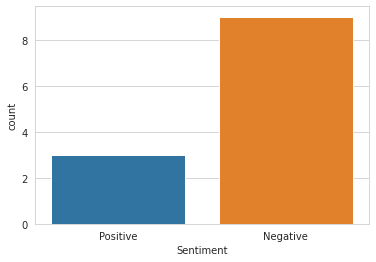

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Sentiment',data=d)

# News Reach
If the No: of retweets and the hashtag counts of a particular tweet croses a threshold, then the reach is considered high else reach is low.

In [ ]:
d['NewsReach'] = d['hashtags_count'].apply(lambda x: 'High' if x > 4 else 'Low')
d.head()

,tweet_id,tweet,tweet_length,symbol_count,urls_count,media_count,retweet_count,favorite_count,hashtags_count,user_mentions,has_smile_emoji,has_place,has_coords,has_quest,has_exclaim,has_quest_or_exclaim,sensitive,hasperiod,number_punct,negativewordcount,positivewordcount,capitalratio,contentlength,sentimentscore,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,has_url_in_text,Sentiment,NewsReach
0,1389462102264487942,RT @ChemicalCC_V2: https://t.co/LF9SJZGpoP\nSo...,140,0,1,NaN,0,0,4,2,0,1,1,False,False,False,0,2,17,0,0,0.142857,15,0.525,9,3,1,2,1,0,1,0,1.0,Positive,Low
1,1389462108606279682,RT @viralbhayani77: The most powerful Fandom i...,140,0,0,NaN,0,0,2.1182,1,0,1,1,False,False,False,1,0,7,0,2,0.0428571,21,0.5,8,5,1,1,0,0,1,0,0.0,Positive,Low
2,1389462151803244548,RT @12thboardexams: #cancel12thboardexams2021 ...,84,0,0,NaN,0,0,4,1,0,1,1,False,False,False,1,0,15,0,0,0.0952381,6,0,5,0,0,0,0,0,0,0,0.0,Negative,Low
3,1389462160753840130,RT @HarryHectic1: Follow Me On @Spotify HarryH...,140,0,0,NaN,0,0,6.8227,2,0,1,1,False,False,False,1,0,12,0,0,0.164286,15,0,14,0,0,0,1,0,0,0,0.0,Negative,High


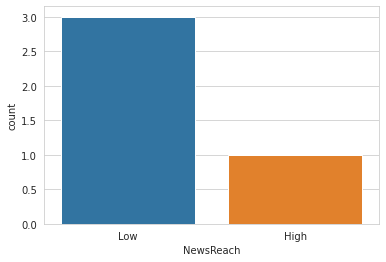

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='NewsReach',data=d)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df['headlines'] = LabelEncoder().fit_transform(df['headlines'].astype('str'))
df['Sentiment'] = LabelEncoder().fit_transform(df['Sentiment'].astype('str'))
df['Sentiment'].value_counts()

In [ ]:
y=d['NewsReach']
X=d[['tweet', 'tweet_length', 'retweet_count', 'hashtags_count', 'negativewordcount', 'positivewordcount',
       'sentimentscore', 'Sentiment']]

In [ ]:
import numpy as np
import pylab as pl
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import pickle
import xgboost as xg
from xgboost import XGBClassifier 
from sklearn.metrics import mean_absolute_error
from time import time
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import f1_score
import requests
from io import StringIO
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_recall_curve, recall_score, precision_score, precision_recall_curve, roc_curve, auc
from matplotlib import cm
from prettytable import PrettyTable
from time import time
from sklearn.decomposition import PCA

Pkl_File = "/content/drive/MyDrive/MLSpring-2021/teams/ninjas/NLP Project/Tripura/HW10/RESULT.pkl"  
names = ["Decision Tree","Random Forest","MLP Neural Net","Nearest Neighbors", "SVM", "AdaBoost"]
classifiers = [
      Pipeline([('clf',DecisionTreeClassifier(max_depth=5))]),
      Pipeline([('clf',RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))]),
      Pipeline([('clf',MLPClassifier(alpha=1, max_iter=1000))]),
      Pipeline([('clf',KNeighborsClassifier(2))]),
      Pipeline([('clf',SVC(kernel="linear", C=0.025))]),
      Pipeline([('clf',AdaBoostClassifier())])
  ]
def Muller_Loop(names, classifiers, X, y):
    
    result = PrettyTable()
    result.field_names = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

    max_score = 0.0
    max_class = ''
 
    # Iterate over classifiers
    for name, clf in zip(names, classifiers):
        start_time = time()
        clf.fit(X_train, y_train)
        score = 100.0 * clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        f1Score = f1_score(y_test, y_pred, average="macro")
        precision = precision_score(y_test,y_pred,average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        if(name == "Decision Tree"):
                  print('Saving model in pickle')
                  with open(Pkl_File, 'wb') as file:  
                    pickle.dump(clf, file)
        print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
        result.add_row([name, score, f1Score, precision, recall])
       
        if score > max_score:
            clf_best = clf
            max_score = score
            max_class = name
    
    print(80*'-' )
    print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
    print(result)


In [ ]:
Muller_Loop(names, classifiers, X, y)